# Task definition and discussion

Here is the task definition as provided by Eshra:

> _**Articles Grouping/Similarity**_
_You have a list of articles with title, URL, and body(Optional). We need to group articles based on the topic for each article. it is a classification and grouping problem. You may need to crawl articles without a body._
>
> _Here is the list of topics(we need to group the articles based on it):
Marketing, Product Management, Company Culture, Business Fundamentals, Product discovery, Startup fundamentals, People management, Business growth, Investment cycle, Branding, Sales And Business Growth, Growth strategies, Company Growth, Growth marketing, Product growth, Product management fundamentals, Agile principles, Business fundamentals, Interpersonal skills, Product discovery_
>
> _**Output:**_
>
> - _JSON file with the same input hierarchy but with extra "topic" field._
> - _Python file with your code._
> - _Documentation of your solution, in only 1 page._

## Interpretation

This task is well-understood from a layperson's point of view: you have a set of articles, and you wish to categorise them into groups. Therefore this is a _"classification and grouping problem"_ as mentioned in the problem statement. One might expect this sort of project request to come from a manager who is unfamiliar with machine learning and natural language processing.

One of the jobs of a senior or lead NLP researcher or engineer is to communicate to non-technical people within the company, and those that may have technical expertise but not in machine learning or natural language processing. We need to communicate what is possible, and to clarify business aims so as to know what to do within a task. It appears that this is also required in this technical assignment.

_Classification_ and _clustering_ (the technical term for "grouping") are fundamentally different types of problems in natural language processing and in machine learning in general, with different definitions, theoretical backgrounds, and tools for solution. Classification is a _supervised_ machine learning task, which means that it requires labelled data in order to carry out. In this case, that would mean a set of articles whose topic we already know. Clustering, on the other hand, is an _unsupervised_ task, which means that we do it without any training data, or any preconceptions about what our results will be like.

The task as stated conflates the two as synonomous (_"It is a classification and grouping problem"_). As a result, it does not distinguish between supervised and unsupervised learning, and the data provided - the labels - are unsuitable for either type of task. One cannot use pre-defined labels when carrying out an unsupervised learning task, as there is no guarantee that these clusters will be those that the algorithm finds in the data. On the other hand, using a few words of text to define a category is not enough data for a supervised learning model - you would need labelled documents.

The manager in question may in fact have been looking for something completely different. Perhaps what they want is, given a label, to find documents relevant to that label. This might sound almost the same from a layperson's point of view, but it actually belongs to a completely different field - that of _information retrieval_.

## Possible approaches

Therefore, this task has to be reinterpreted either as a supervised learning task, an unsupervised learning task, or an information retrieval task. There are disadvantages to each of these approaches - our manager is likely to be dissatisfied whatever happens, unless we are careful to communicate the issues with the problem definition (as I have tried to above).

As an unsupervised learning task (clustering), we might use a method like _Latent Dirichlet Allocation_ (LDA) to split up the articles into a pre-defined number of topics (here around 20, to fit with the number of labels provided in the task). The algorithm will divide the documents without any interpretation of what the topics actually _mean_, though, and so we will have to look at each cluster by hand and decide what we think that cluster has in common. There is no guarantee that it will match the labels we started with - in fact, it is highly unlikely to cluster them according to our pre-existing desires or intuitions. This violates a central aim of the task, which is to fit to the labels specified.

As a supervised learning task (categorisation), we might use a method like _logistic regression_. In order to do so, we would need a training data set. Since none has been provided, I would have to generate it myself, perhaps by scraping the Wikipedia article for each label. The reason I would consider Wikipedia is that it is a publicly available clean corpus, where all the documents are written in a similar style, and it would be relatively easy to find documents for most of the labels. 

However, there are at least two issues with this approach. Firstly, this would only provide the same number of training examples as there are labels, which means that the model would be in grave danger of _overfitting_. Overfitting is when unimportant features of individual training examples are used by the model as significant pieces of information - in this case an example would mean taking the chance absence of an unimportant word ("still" or "think", for example) from the Wikipedia article on "marketing" to be a hallmark of this category. Secondly, the fact that Wikipedia articles are written in a different style to the articles in the data set means that strange and unsatisfying results are even more likely.

As an information retrieval task, we could simply search for the label's terms appearing in the document. If this seems too simple, we could augment the set of terms to search for by finding similar terms, such as the nearest neighbours in a distributional semantic model like Word2Vec. The disadvantage of this approach is that each document may receive several labels, and some may receive no labels, which is not what was originally asked for.

## Weighing up the options

Ultimately, it boils down to choosing the "lesser evil" from among the following disadvantages:

1. we will not fit to the lables given, but get a clustering which may not reflect the labels we are interested in (unsupervised learning / clustering / LDA)
2. we will get what training data we can in the time, resulting in overfitting due to a small data set, and likely get a poor categorisation because the training data is a different kind of data set to our test data (e.g. different writing style, different register, different audience) (supervised learning / categorisation)
3. rather than giving each document a single label, they may get multiple labels, and some will get none at all (information retrieval)

On balance, my interpretation is that the third option would be the least bad. This is what I will go with in the execution of the exercise below.

# Imports

In [1]:
### GENERAL
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

### DATA CLEANING
from collections import Counter
import re
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
stem = stemmer.stem

### EXPANDING QUERIES USING WORD VECTORS
from gensim.models import KeyedVectors
import bz2

### DATA VISUALISATION
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
ARTICLES_PATH = './data/articles (1).json'

# Data probing

Before continuing, let us look at the data we have been provided, in order to get a sense of what we are working with.

## Documents

First, let's look at our documents.

How many documents do we have? And how many of them have missing bodies?

In [3]:
df = pd.read_json(path_or_buf=ARTICLES_PATH, orient='records')
print("There are %s articles." % len(df))
print("%s of them don't have bodies." % len(df[df.body == '']))

There are 117 articles.
97 of them don't have bodies.


Do they all have titles and URLs?

In [4]:
print("There are %d articles with missing titles, and %d with missing URLs." % (len(df[df.title == '']), len(df[df.url == ''])))

There are 0 articles with missing titles, and 0 with missing URLs.


Ok, so most of the bodies are missing, but all the titles and URLs are there. Some thoughts:

1. If I want to use the bodies for all the articles (not just those for which bodies have been provided), I am going to have to do scrapes. Copying these articles by hand is possible in this scale of problem, but it will not be a sustainable solution - what if tomorrow Ahmed asks me to categorise 10,000 articles from URLs?
2. It may be possible to categorise the articles based on their _titles alone_. This would avoid having to have all the bodies, which means that the work could be done quicker. The disadvantage of this is I would be throwing away a lot of data which would be useful. Titles are very short as well, so there might be cases where they are misleading - and you can't check whether they are misleading or not without looking at the original articles.

## Labels

What about the labels? What are they again?

In [5]:
LABELS = [
    "Agile principles",
    "Branding",
    "Business Fundamentals",
    "Business fundamentals",
    "Business growth",
    "Company Culture",
    "Company Growth",
    "Growth marketing",
    "Growth strategies",
    "Interpersonal skills",
    "Investment cycle",
    "Marketing",
    "People management",
    "Product Management",
    "Product discovery",
    "Product discovery",
    "Product growth",
    "Product management fundamentals",
    "Sales And Business Growth",
    "Startup fundamentals"
]

There is some repetition there. This could do with a clean.

In [6]:
print("Started with %d labels." % len(LABELS))
LABELS = sorted(list(set(term.lower() for term in LABELS)))
print("Now we have %d labels." % len(LABELS))
LABELS

Started with 20 labels.
Now we have 18 labels.


['agile principles',
 'branding',
 'business fundamentals',
 'business growth',
 'company culture',
 'company growth',
 'growth marketing',
 'growth strategies',
 'interpersonal skills',
 'investment cycle',
 'marketing',
 'people management',
 'product discovery',
 'product growth',
 'product management',
 'product management fundamentals',
 'sales and business growth',
 'startup fundamentals']

There are a few more duplicates that I can see "by eye":

- _product management_ and _product management fundamentals_
- _company growth_ and _business growth_ and _growth strategies_
- _growth marketing_ and _marketing_

I will remove all but one of each of these lists.
I will also simplify _sales and business growth_ to _sales_.

In [7]:
for label in ["product management fundamentals", "business growth", "growth strategies", "growth marketing"]:
    LABELS.remove(label)

LABELS = ["sales" if label=="sales and business growth" else label for label in LABELS]
print(LABELS)
print("Now we have %d labels." % len(LABELS))

['agile principles', 'branding', 'business fundamentals', 'company culture', 'company growth', 'interpersonal skills', 'investment cycle', 'marketing', 'people management', 'product discovery', 'product growth', 'product management', 'sales', 'startup fundamentals']
Now we have 14 labels.


## Plan of attack

Here is my plan:

1. Work on just the articles with bodies provided to start with.
2. Make a function to clean up the bodies into a usable state - remove punctuation and whitespace, lowercase, and lemmatise or stem.
3. Make a function to expand queries from the labels, by using nearest neighbours in word embeddings.
4. Make a function to calculate the number of times stems from the queries appear in the article bodies, and use the maximum value as the label.
5. Normally, at this stage I would want to do validation. I don't think I will have time for this (and since I have no training data / ground truth, it's not possible anyway).
6. Normally, at this stage, I would want to scrape the rest of the articles from their URLs in order to be able to be able to do a proper analysis on them, but I don't think that I'll have time, in which case I will apply the method using functions outlined in points 2-4 but on just the titles. This is less likely to give a satisfactory result as titles are short, but I can try it out in any case.

# Data cleaning

Stemming is a much more harsh process than lemmatising. The disadvantage of this is that it can introduce false positives, as you may not want "companion" to match "company". However, in a low-data problem like this, stemming is preferred as it will identify words with the same root, such as "develop" and "development", and there may be few "hits" otherwise. If using lemmatisation, these would not be counted as the same word across documents.

In [8]:
def clean_tokenise_stop_stem(article):
    '''
    Make all text lower case.
    Replace line breaks with spaces, then tokenise the text.
    Remove stop words (high-frequency uninformative words like "the", "be", and "which").
    Stem each token.
    Make a dictionary of counts for each stem (this will be useful for performance later, when doing lookups).
    '''
    article = article.lower().replace('\n', ' ').replace('\r', '')
    alphanumRegex = re.compile('[^0-9A-Za-z]')
    tokens = alphanumRegex.split(article) # note that this still may include empty strings - removed in next line
    stems = [stem(token) for token in tokens if token != '' and token not in stopWords]
    return Counter(stems)

# Expanding queries using word vectors

We will find the nearest neighbours using GenSim. We will use bag-of-words-based word embeddings as these tend to rate words in the same _topic_ as similar, while dependency-based word embeddings tend to rate words with a similar _function_ as similar. See https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf for a discussion.

Note that we could expand these topics _by hand_ rather than using an NLP model to do so. This would be a more accurate approach in the short-term. However, this becomes cumbersome if we have to do it for every label we come across, which may be different in future.

First, load the vectors from bz2 zipped format.

In [9]:
def load_vectors_bz2(path):
    words = []
    vectors = []
    with bz2.open(path, 'rt') as f:
        for line in f.readlines():
            word, vector = line.split(' ', 1)
            vector = np.array([float(_) for _ in vector.split(' ')])
            words.append(word)
            vectors.append(vector)
    assert(len(words) == len(vectors))
    print("Generated %d word vectors." % len(vectors))
    wv = KeyedVectors(vector_size=vector.shape[0])
    wv.add(entities=words, weights=vectors) # relates words to their associated vectors
    return wv

**IMPORTANT**: If you want to run the below code, you will need to download the word vectors. They are available for download from this location: http://u.cs.biu.ac.il/~yogo/data/syntemb/bow2.words.bz2. This file is over 300 MB in size which is why I've gitignored it from the repo. Once the download completes, put the file in the `data` directory of this project and continue executing the code.

Note also that the below single line of code takes about two minutes to run. I suggest that you run it only once.

In [10]:
vectors = load_vectors_bz2('./data/bow2.words.bz2')

Generated 183870 word vectors.


Now find the nearest neighbours. Note that this algorithm tries to find terms that are close to _all_ input words, so if the words are very different we may get an empty result.

In [11]:
def find_topic_neighbour_stems(words, topn=20, clip_end=20000):
    '''
    Find the nearest neighbours of the two terms, and return their stems, in order of distance (nearest first).
    Add the stem of the term itself to this list also.
    topn: the number of words to return
    clip_end: the upper limit on word frequency rank (if this number is smaller, more infrequent words will be excluded)
    '''
    # in the below line, we set a larger topn so that we can remove duplicates and still have topn be the number of results
    topic_neighbours = vectors.most_similar(words, topn=topn*2, restrict_vocab=clip_end)
    # the terms themselves are top of the list of course!
    stems = [stem(word) for word in words]
    # then add the nearest neigbours
    stems.extend([stem(word) for word,score in topic_neighbours])
    # remove duplicates, preserve order
    stemSet = set()
    deduped_stems = []
    for s in stems:
        if s not in stemSet:
            deduped_stems.append(s)
            stemSet.add(s)
    return deduped_stems[:topn]

Now let's expand the queries that the labels represent, formatting the result into a convenient data structure.

In [12]:
LABEL_QUERIES = {
    label: find_topic_neighbour_stems(label.split(' ')) + [label]
        for label in LABELS
}
LABEL_QUERIES

{'agile principles': ['agil',
  'principl',
  'concept',
  'philosophi',
  'methodolog',
  'method',
  'strategi',
  'doctrin',
  'intuit',
  'object',
  'robust',
  'innov',
  'intellig',
  'techniqu',
  'ideal',
  'pragmat',
  'idea',
  'basic',
  'practic',
  'effici',
  'agile principles'],
 'branding': ['brand',
  'logo',
  'monik',
  'market',
  'on-air',
  'slogan',
  'rebrand',
  'relaunch',
  'signag',
  'liveri',
  'advertis',
  'packag',
  'program',
  'network',
  'sponsorship',
  'label',
  'format',
  'mascot',
  'style',
  'simulcast',
  'branding'],
 'business fundamentals': ['busi',
  'fundament',
  'entrepreneurship',
  'basic',
  'concept',
  'econom',
  'principl',
  'sociolog',
  'methodolog',
  'industri',
  'mathemat',
  'ict',
  'market',
  'engin',
  'technolog',
  'aesthet',
  'financ',
  'special',
  'philosophi',
  'sustain',
  'business fundamentals'],
 'company culture': ['compani',
  'cultur',
  'conglomer',
  'industri',
  'corpor',
  'retail',
  'textil

# Dataframe preparation

We need to add a bunch of fields to the dataframe which were not present in the `.json` file.

In [13]:
def prepare_dataframe(dataframe, textColumn):
    '''
    Pre-process the text to clean it, tokenise it, and stem the tokens.
    Expand the dataframe to include a score column for each label, and an overall predicted label column.
    '''
    dataframe["stems"] = dataframe[textColumn].map(clean_tokenise_stop_stem)
    
    nullList = [None for i in range(len(dataframe))]
    dataframe["labels"] = list(nullList)
    for label in LABEL_QUERIES:
        dataframe[label] = list(nullList)
    
    return dataframe

# Calculating scores

This is where we do the actual counting of hits, in order to decide what the best label(s) might be.

In [14]:
def calculate_score_columns_and_winner(dataframe):
    '''
    For each label, check how many times the word occurs in the body text.
    This is the score of that document for that label. 
    Then use the maximum score to assign the label for that article.
    '''
    collisions,nulls = 0,0
    
    for _,row in dataframe.iterrows():
        best = ([],0)
        
        for label,terms in LABEL_QUERIES.items():
            occurrences = [row.stems[term] for term in terms]
            score = sum(occurrences)
            row[label] = score
            if score > best[1]:
                best = ([label],score)
            elif score > 0 and score == best[1]:
                # Note that this violates the requirement of one label per document.
                best[0].append(label)

        row['labels'] = best[0]
        if len(best[0]) == 0:
            nulls +=1
        elif len(best[0]) > 1:
            collisions +=1
            
    print("** NUMBER OF UNCLASSIFIED DOCUMENTS: %d **" % nulls)
    print("** NUMBER OF COLLISIONS: %d **" % collisions)

# Executing the analysis on document bodies

In [15]:
articlesWithBodies = df[df.body != ""]
calculate_score_columns_and_winner(prepare_dataframe(articlesWithBodies, "body"))
articlesWithBodies.head()

** NUMBER OF UNCLASSIFIED DOCUMENTS: 0 **
** NUMBER OF COLLISIONS: 1 **


,body,title,url,stems,labels,agile principles,branding,business fundamentals,company culture,company growth,interpersonal skills,investment cycle,marketing,people management,product discovery,product growth,product management,sales,startup fundamentals
10,Product Development: Turning Months Into Weeks...,Product Development: Turning Months Into Weeks,http://www.mindtheproduct.com/2017/07/product-...,"{'product': 9, 'develop': 5, 'turn': 1, 'month...",[product discovery],3,0,4,3,11,2,2,1,0,17,9,10,11,5
12,"With digital media always changing, it's impor...",What is Growth Hacking and How to Use it for Y...,http://FI.co/posts/31391,"{'digit': 3, 'media': 3, 'alway': 1, 'chang': ...",[sales],13,25,42,5,28,7,3,39,6,8,30,44,49,21
16,"Adeo Ressi, the co-founder and CEO of the Foun...",Don’t Build a Business Unless You’re Ready to ...,http://FI.co/posts/28951,"{'adeo': 3, 'ressi': 1, 'co': 1, 'founder': 13...",[business fundamentals],11,5,20,11,15,3,8,18,9,11,4,11,7,8
19,Finding the right investors is like dating — y...,The 7 (Pitching) Habits of Highly Effective Fo...,http://500.co/7-pitching-habits-for-founders,"{'find': 5, 'right': 3, 'investor': 14, 'like'...",[sales],0,4,9,2,6,1,4,7,7,6,7,9,10,3
22,When Asana was a young company of just a few p...,How Roadmap Week helps us turn big ideas into ...,https://wavelength.asana.com/work-plans-high-l...,"{'asana': 3, 'young': 1, 'compani': 3, 'peopl'...",[agile principles],17,0,0,3,3,2,0,0,6,6,6,7,5,4


# Executing the analysis on document titles

Now that we've tried doing this with document bodies, let's do something similar with titles. For this, we can use the entire original list of articles, as we've already checked that every article has a title.

In [16]:
allArticles = df.copy(deep=True)
calculate_score_columns_and_winner(prepare_dataframe(allArticles, "title"))
allArticles.head(30)

** NUMBER OF UNCLASSIFIED DOCUMENTS: 18 **
** NUMBER OF COLLISIONS: 59 **


,body,title,url,stems,labels,agile principles,branding,business fundamentals,company culture,company growth,interpersonal skills,investment cycle,marketing,people management,product discovery,product growth,product management,sales,startup fundamentals
0,,Understanding Business Development,http://sethgodin.typepad.com/seths_blog/2009/0...,"{'understand': 1, 'busi': 1, 'develop': 1}","[business fundamentals, company growth, market...",0,0,1,0,1,0,0,1,0,0,0,0,0,0
1,,What are different types of Marketing Research?,http://whatismarketresearch.com/market-researc...,"{'differ': 1, 'type': 1, 'market': 1, 'researc...","[branding, business fundamentals, marketing, p...",0,1,1,0,0,0,0,1,0,0,0,1,1,0
2,,5 Low-Cost Marketing Research Techniques for S...,https://www.credibly.com/incredibly/5-low-cost...,"{'5': 1, 'low': 1, 'cost': 1, 'market': 1, 're...","[business fundamentals, marketing]",1,1,2,0,0,1,0,2,0,0,0,1,1,0
3,,Are Product Managers the New Software Engineers?,https://hired.com/blog/highlights/product-mana...,"{'product': 1, 'manag': 1, 'new': 1, 'softwar'...",[product management],0,0,1,0,0,0,0,1,1,1,1,2,1,1
4,,500 Startups: The How-To Guide for Finding Pro...,https://medium.com/founder-playbook/500-startu...,"{'500': 1, 'startup': 1, 'guid': 1, 'find': 1,...","[product management, sales]",0,1,1,0,0,0,0,1,0,1,1,2,2,1
5,,COMPETITIVE ANALYSIS PART 2: HOW TO ANALYZE CO...,https://www.campaigncreators.com/blog/competit...,"{'competit': 2, 'analysi': 1, 'part': 1, '2': ...",[],0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,,7 TECHNICAL SKILLS ALL GROWTH HACKERS SHOULD L...,https://buckfiftymba.com/7-technical-skills-gr...,"{'7': 1, 'technic': 1, 'skill': 1, 'growth': 1...","[company growth, interpersonal skills, product...",0,0,0,0,1,1,0,0,0,0,1,0,0,0
7,,The Importance of Lead Generation,https://criteriaforsuccess.com/the-importance-...,"{'import': 1, 'lead': 1, 'generat': 1}",[sales],0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,,Market Research,https://www.entrepreneur.com/encyclopedia/mark...,"{'market': 1, 'research': 1}","[branding, business fundamentals, marketing, p...",0,1,1,0,0,0,0,1,0,0,0,1,1,0
9,,KANBAN AND AGILE,https://leankit.com/learn/kanban/kanban-agile/,"{'kanban': 1, 'agil': 1}",[agile principles],1,0,0,0,0,0,0,0,0,0,0,0,0,0


The number of unclassified documents, or documents where more than one label drew for the result, is a huge proportion of the total:

In [17]:
print('''%.1f%% of the documents with titles only were unclassified, and %.1f%% had a draw for top label
(and hence multiple labels). This leaves only %.1f%% as having been "successfully" labelled (with only one label).'''
     % (100*18/97, 100*59/97, 100*(97-18-59)/97))

18.6% of the documents with titles only were unclassified, and 60.8% had a draw for top label
(and hence multiple labels). This leaves only 20.6% as having been "successfully" labelled (with only one label).


# Analysing the label distribution

We may have expectations of how spread out the labels are over the documents. We wouldn't want all of the documents to be given one label and the other labels be ignored, for example. Here is a quick data visualisation to get a sense of how we are doing.

In [18]:
def plot_label_distribution(dataframe):
    distribution = { label: 0 for label in LABELS }
    for _,row in dataframe.iterrows():
        for label in row.labels:
            distribution[label] +=1
    # tuples sorted according to their numerical value (number of occurrences)
    #name_value_tups = sorted(list(distribution.items()), key=lambda tup: tup[1])
    name_value_tups = list(distribution.items())
    # unpacks [(labels), (values)]
    objects, performance = list(zip(*name_value_tups))
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation='vertical')
    plt.ylabel('Number of times label used')
    plt.show()

First, the distribution for **document-based** analysis.

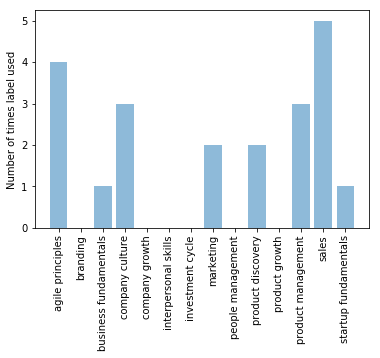

In [19]:
plot_label_distribution(articlesWithBodies)

Now, the distribution for **title-based** analysis. The x-labels are in the same order so you can compare both charts one above the other.

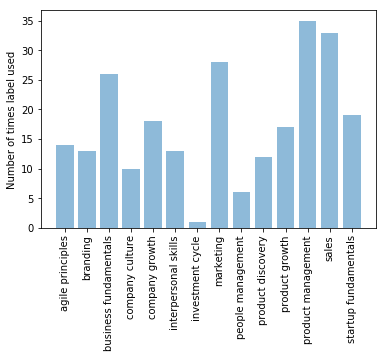

In [20]:
plot_label_distribution(allArticles)

It looks as though the spread of the labels is not a major problem - it is not the case that a few labels are completely dominating. The fact that the first chart shows a less even distribution could partly be down to the fact that the number of documents is so low.

# CONCLUSION

The task left significant room for interpretation in terms of what was actually wanted, and how to go about providing it. I interpreted it as an information retrieval task, using a collection of terms similar to those in the label as search terms in the documents. I checked whether documents were getting labels (rather than getting no label), and that the distribution of labels was not too highly concentrated on a small subset of labels, but otherwise did not carry out any validation.

As one might expect, in the case of trying to label the documents based only on their titles, the information retrieval approach gives most of the documents no label at all.

As further work, one might consider scraping the documents with the given URLs in order to do a document-based analysis on all the documents in the set. One could also try a supervised or unsupervised learning approach. But the most important thing to do would be to clarify exactly what is required in the task by communicating with the managers and the rest of the team. Only then will it be possible to come up with an approach that is both feasible from an NLP perspective, and satisfies the business requirements.

# Saving results to .json

In [21]:
def cropped_dataframe(dataframe):
    return pd.concat([
        dataframe['body'],
        dataframe['title'],
        dataframe['url'],
        dataframe['labels']
    ], axis=1)

articlesWithBodiesCropped = cropped_dataframe(articlesWithBodies)
articlesWithBodiesCropped.to_json(path_or_buf='./results/results_using_bodies.json', orient='records')

allArticlesCropped = cropped_dataframe(allArticles)
allArticlesCropped.to_json(path_or_buf='./results/results_using_titles.json', orient='records')